# CNN 原始模型

In [1]:
import jieba
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Conv2D, GlobalMaxPool2D, Embedding, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json

In [2]:
# 批次大小
batch_size = 128
# 训练周期
epochs = 1
# 词向量长度
embedding_dims = 128
# 滤波器数量
filters = 32
# 这个数据前半部分都是正样本，后半部分都是负样本
data = pd.read_csv('weibo_senti_100k.csv')
# 查看数据前 5 行
data.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [3]:
# 计算正样本数量
poslen = sum(data['label']==1)
# 计算负样本数量
neglen = sum(data['label']==0)
print('正样本数量：', poslen)
print('负样本数量：', neglen)

正样本数量： 59993
负样本数量： 59995


In [4]:
# 测试一下结巴分词的使用
print(list(jieba.cut('谎言重复一千遍就成了真理。 --纳粹德国宣传部长')))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\31600\AppData\Local\Temp\jieba.cache
Loading model cost 0.629 seconds.
Prefix dict has been built successfully.


['谎言', '重复', '一千遍', '就', '成', '了', '真理', '。', ' ', '--', '纳粹德国', '宣传部长']


In [6]:
#定义匿名分词函数，对传入的 x 进行分词，返回一个包含了分词后结果的生成器对象
cw = lambda x: list(jieba.cut(x))  # 返回一个列表
# pandas的apply函数接受一个传入的函数，即把 cw 函数应用到 data['review']这一列的每一行
data['words'] = data['review'].apply(cw)

In [7]:
# 再查看数据前 5 行
data.head()

,label,review,words
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],"[﻿, 更博, 了, ，, 爆照, 了, ，, 帅, 的, 呀, ，, 就是, 越来越, 爱..."
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,"[@, 张晓鹏, jonathan, , 土耳其, 的, 事要, 认真对待, [, 哈哈,..."
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...,"[姑娘, 都, 羡慕, 你, 呢, …, 还有, 招财猫, 高兴, …, …, /, /, ..."
3,1,美~~~~~[爱你],"[美, ~, ~, ~, ~, ~, [, 爱, 你, ]]"
4,1,梦想有多大，舞台就有多大![鼓掌],"[梦想, 有, 多, 大, ，, 舞台, 就, 有, 多, 大, !, [, 鼓掌, ]]"


In [8]:
# 计算一条数据最多有多少个词汇
max_length = max([len(x) for x in data['words']])
max_length

202

In [9]:
# 把 data['words']中所有的 list 都变成字符串格式
texts = [' '.join(x) for x in data['words']]
# 查看一条评论，现在数据变成了字符串格式，并且词与词之间用空格隔开
# 这是为了满足下面数据处理对格式的要求，下面要使用 Tokenizer 对数据进行处理
print(texts[4])

梦想 有 多 大 ， 舞台 就 有 多 大 ! [ 鼓掌 ]


In [10]:
# 实例化 Tokenizer，设置字典中最大词汇数为 30000
# Tokenizer 会自动过滤掉一些符号比如：!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n
tokenizer = Tokenizer(num_words=30000)
# 传入我们的训练数据，建立词典，词的编号根据词频设定，频率越大，编号越小，
tokenizer.fit_on_texts(texts)
# 把词转换为编号，编号大于 30000 的词会被过滤掉
sequences = tokenizer.texts_to_sequences(texts)
# 把序列设定为 max_length 的长度，超过 max_length 的部分舍弃，不到 max_length 则补0
# padding='pre'在句子前面进行填充，padding='post'在句子后面进行填充
X = pad_sequences(sequences, maxlen=max_length, padding='pre')
# 获取字典
dict_text = tokenizer.word_index

In [11]:
# 在字典中查询词对应编号
print(dict_text['中国'])

94


In [12]:
# 把 token_config 保存到 json 文件中，模型预测阶段可以使用
file = open('token_config.json','w',encoding='utf-8')
# 把 tokenizer 变成 json 数据
token_config = tokenizer.to_json()
# 保存 json 数据
json.dump(token_config, file)

In [13]:
print(X[4])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  581   18   75   77    1
 1946 

In [14]:
# 定义标签
# 01 为正样本，10 为负样本
positive_labels = [[0, 1] for _ in range(poslen)]
negative_labels = [[1, 0] for _ in range(neglen)]
# 合并标签
Y = np.array(positive_labels + negative_labels)
# 切分数据集
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

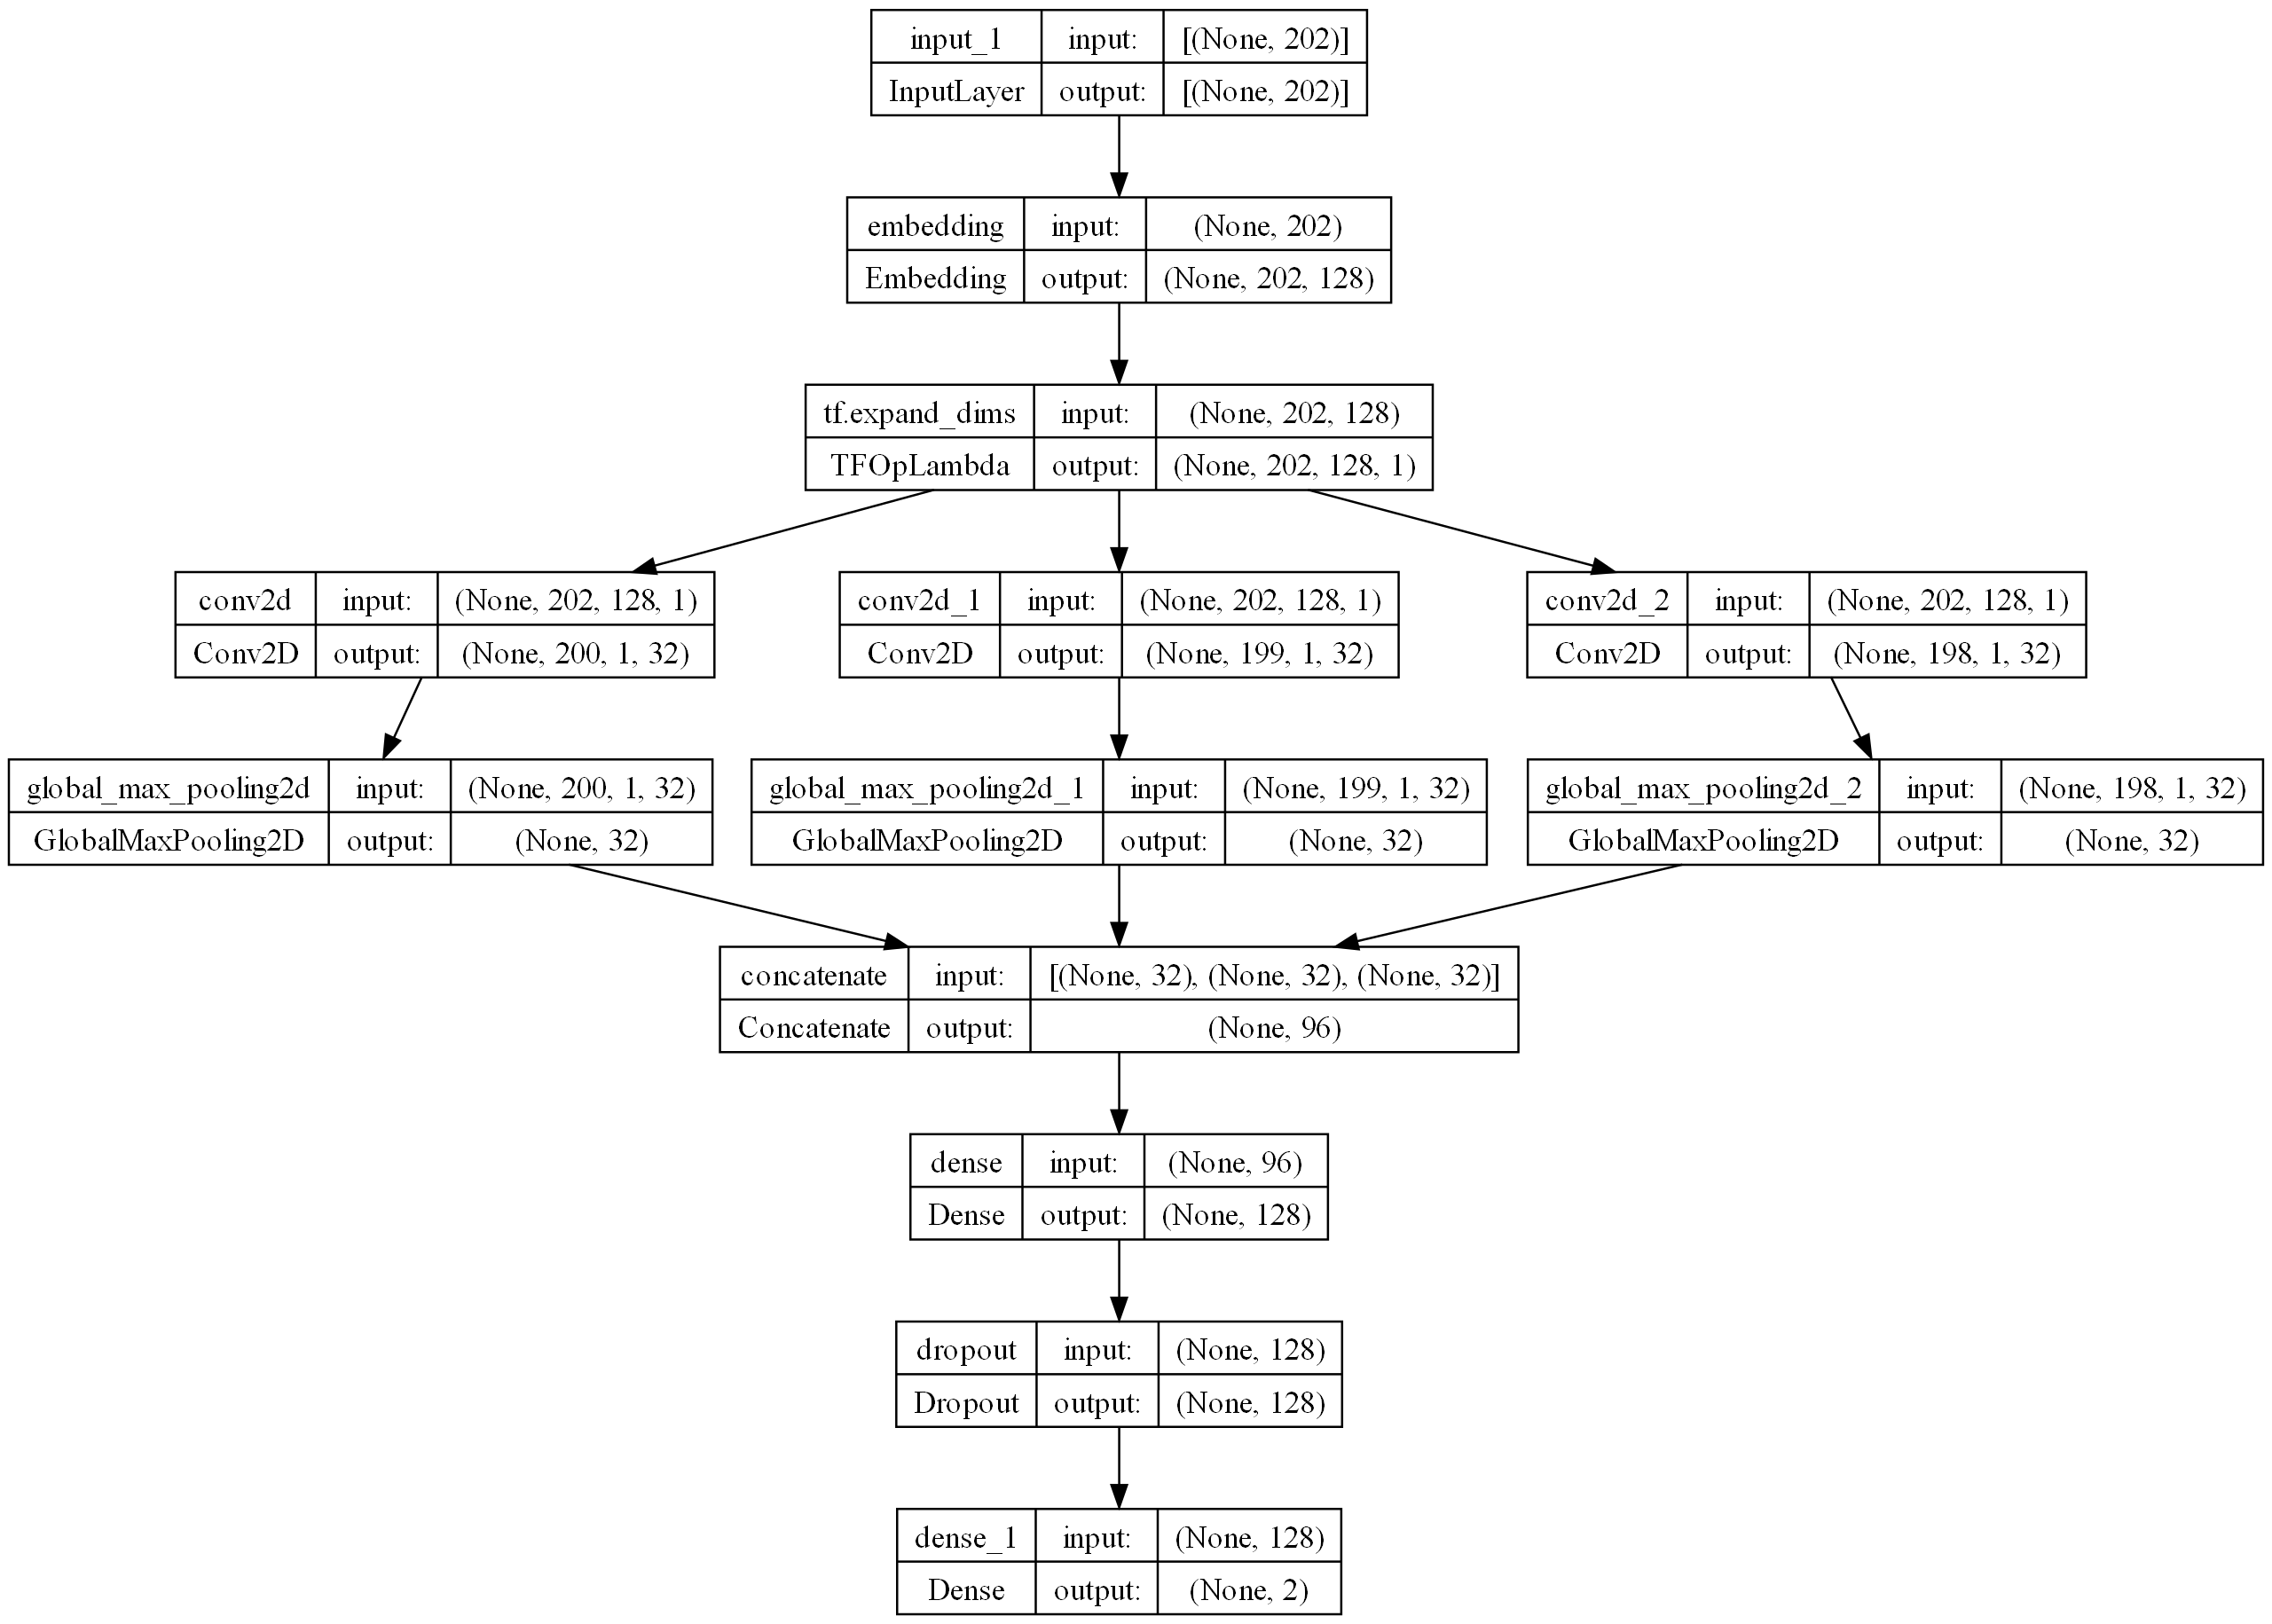

In [14]:
# 定义模型输入，shape-(batch, 202)
sequence_input = Input(shape=(max_length,))
# Embedding 层，30000 表示 30000 个词，每个词对应的向量为 embedding_dim 维
embedding_layer = Embedding(input_dim=30000, output_dim=embedding_dims)
# embedded_sequences 的 shape-(batch, 202, 128)
embedded_sequences = embedding_layer(sequence_input)
# embedded_sequences 的 shape 变成了(batch, 202, 128, 1)
embedded_sequences = K.expand_dims(embedded_sequences, axis=-1)
# 卷积核大小为 3,列数必须等于词向量长度
cnn1 = Conv2D(filters=filters, kernel_size=(3,embedding_dims), activation='relu')(embedded_sequences)
cnn1 = GlobalMaxPool2D()(cnn1)
# 卷积核大小为 4,列数必须等于词向量长度
cnn2 = Conv2D(filters=filters, kernel_size=(4,embedding_dims), activation='relu')(embedded_sequences)
cnn2 = GlobalMaxPool2D()(cnn2)
# 卷积核大小为 5,列数必须等于词向量长度
cnn3 = Conv2D(filters=filters, kernel_size=(5,embedding_dims), activation='relu')(embedded_sequences)
cnn3 = GlobalMaxPool2D()(cnn3)
# 合并
merge = concatenate([cnn1, cnn2, cnn3], axis=-1)
# 全连接层
x = Dense(128, activation='relu')(merge)
# Dropout层
x = Dropout(0.5)(x)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)
plot_model(model, show_shapes=True, dpi=180)

In [30]:
# 定义代价函数，优化器
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
# 训练模型
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
# 保存模型
model.save('cnn_model.h5')

750/750 [==============================] - 1112s 1s/step - loss: 0.0504 - acc: 0.9800 - val_loss: 0.0415 - val_acc: 0.9825


**因为原始数据中有大量表情符号，如[爱你]，[哈哈]，[鼓掌]，[可爱]等，这些表情符号中对应的文字从较大程度上代表了这一句话的情感。所以我们做的这个项目之所以得到这么高的准确率，跟这里的表情符号是有很大关系。大家如果使用其他数据集来做情感分类，应该也会得到不错的结果，但是应该很难得到 98%这么高的准确率。**

In [33]:
# 载入 tokenizer
json_file = open('token_config.json','r',encoding='utf-8')
token_config = json.load(json_file)
tokenizer = tokenizer_from_json(token_config)
# 载入模型
model = load_model('cnn_model.h5')

In [34]:
# 情感预测
def predict(text):
    # 对句子进行分词
    cw = list(jieba.cut(text))
    # 将列表转为字符串
    texts = ' '.join(cw)
    # 将词转为编号
    sequences = tokenizer.texts_to_sequences([texts])
    sequences = pad_sequences(sequences, maxlen=model.input_shape[1], padding='pre')
    # 模型预测
    res = np.argmax(model.predict(sequences))
    if res == 1:
        print("正面情绪")
    else:
        print("负面情绪")

In [47]:
predict("小明今天的考试不及格[失落]")
predict("小明今天的考试不及格[崩溃]")

1/1 [==============================] - 0s 19ms/step
正面情绪
1/1 [==============================] - 0s 18ms/step
负面情绪


**从上面这个例子更能直观的看出训练得到的模型能得到这么高的准确率跟表情符号有很大关系。**

# 尝试使用双向 LSTM 改进

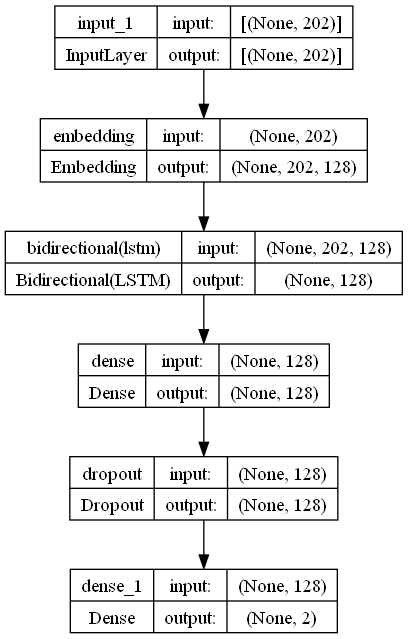

In [15]:
# 很多其他超参数与原CNN模型相同，故这里不再定义，直接沿用
epochs = 3
# cell 数量
lstm_cell = 64
# 数据预处理也直接沿用CNN模型的做法，这里也不给出实现，直接定义模型

# 定义模型输入，shape-(batch, 202)
sequence_input = Input(shape=(max_length,))
# Embedding 层，30000 表示 30000 个词，每个词对应的向量为 128 维
embedding_layer = Embedding(input_dim=30000, output_dim=embedding_dims)
# embedded_sequences 的 shape-(batch, 202, 128)
embedded_sequences = embedding_layer(sequence_input)
# 双向 LSTM
x = Bidirectional(LSTM(lstm_cell))(embedded_sequences)
# 全连接层
x = Dense(128, activation='relu')(x)
# Dropout 层
x = Dropout(0.5)(x)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)
# 画图
plot_model(model, show_shapes=True)

In [55]:
# 定义代价函数，优化器
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
# 训练模型
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
# 保存模型
model.save('lstm_model.h5')

Epoch 1/3
750/750 [==============================] - 31s 38ms/step - loss: 0.1160 - acc: 0.9647 - val_loss: 0.0640 - val_acc: 0.9824
Epoch 2/3
750/750 [==============================] - 36s 48ms/step - loss: 0.0506 - acc: 0.9815 - val_loss: 0.0456 - val_acc: 0.9822
Epoch 3/3
750/750 [==============================] - 34s 45ms/step - loss: 0.0438 - acc: 0.9814 - val_loss: 0.0541 - val_acc: 0.9815


**从准确率看，该模型并未取得比原始CNN模型更好的表现，不过训练代价相比却大大降低。在相同GPU资源的情况下，训练一个epoch的时间少了32倍。**

In [56]:
# 载入 tokenizer
json_file = open('token_config.json','r',encoding='utf-8')
token_config = json.load(json_file)
tokenizer = tokenizer_from_json(token_config)
# 载入模型
model = load_model('lstm_model.h5')

In [59]:
predict("小明今天的数学考了90分[失落]")
predict("小明今天的数学考了90分[伤心]")

1/1 [==============================] - 0s 25ms/step
正面情绪
1/1 [==============================] - 0s 24ms/step
负面情绪
